In [2]:
from os import listdir
from sys import argv

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.metrics import f1_score, roc_curve, roc_auc_score, precision_recall_curve, accuracy_score

from sklearn.ensemble import RandomForestClassifier as RFC
from sklearn.decomposition import PCA

from sklearn.model_selection import train_test_split

import sys
sys.path.insert(0, "/mnt/Dados/Documentos/xgboost/python-package/")
import xgboost as xgb

from sklearn.feature_selection import SelectPercentile
from sklearn.feature_selection import f_classif,chi2
from sklearn.preprocessing import Binarizer, scale, StandardScaler, minmax_scale

from sklearn.svm import SVC

import time

from sklearn.externals import joblib
import pandas as pd
from sklearn.manifold import Isomap, TSNE
from sklearn.model_selection import GroupKFold, LeavePGroupsOut, LeaveOneGroupOut

def shuffled(array):
    x = array.values.copy()
    np.random.shuffle(x)
    return x

def shuffled2(array):
    x = array.copy()
    np.random.shuffle(x)
    return x

# import pyperclip

In [3]:
# Read database from disk
data = pd.read_csv("PIXELdatasetfull.csv")

In [4]:
# Shuffle data
data = data.loc[shuffled(data.index)]

In [5]:
# Copy not-feature data from the base, before removing them for training purpose

y = data["GT"]
IMG = data["IMG"]
solo = data["solo"]
base = data["base"]

In [6]:
# Remove not-feature data from the base, for training purpose

del data["GT"]
del data["IMG"] # big jump in precision by keeping this feature
del data["solo"]
del data["base"]

# 0)  AUC and Mean Acc. Analysis of everything

In [7]:
def getBestTreshold(FPR, TPR, TH):
    """This function is for calculating the Mean Accuracy, given a ROC curve"""
    i_max = max(range(len(TPR)), key = lambda x : TPR[x] + 1 - FPR[x])
    mean_accuracy = (TPR[i_max] + 1 - FPR[i_max])/2
    return mean_accuracy, TH[i_max]

In [8]:
def getPerformance(true, prediction):
    auc = roc_auc_score(true, prediction)        
    fpr, tpr, th = roc_curve(true, prediction)
    if auc < .5:
        fpr, tpr = tpr, fpr
        auc = 1 - auc
    mean_acc, bestTH = getBestTreshold(fpr, tpr, th)
    return auc, mean_acc, bestTH, fpr, tpr

In [9]:
def splitByImages(data, test_size, repetitions):
    images = list(set(IMG.loc[data.index]))
    n = len(images)
    for _ in range(repetitions):
        np.random.shuffle(images)
        split_point = int(n * (1-test_size))
        yield images[:split_point], images[split_point:]

In [14]:
def XGBTrain(data, train_imgs, val_imgs, y):

    X_train, y_train = data.loc[IMG.isin(train_imgs)], y.loc[IMG.isin(train_imgs)]
    X_val, y_val = data.loc[IMG.isin(val_imgs)], y.loc[IMG.isin(val_imgs)]
    
    ratio = float(np.sum(y_train == 1)) / np.sum(y_train==0)

    clf = xgb.XGBClassifier(
                    max_depth = 4,
                    n_estimators=250,
                    learning_rate=0.2, 
                    nthread=5,
                    subsample=1.0,
                    colsample_bytree=1,
                    scale_pos_weight = ratio,
                    reg_alpha=0.03,
                    seed=1301)

    clf.fit(X_train, y_train, early_stopping_rounds=20, eval_metric="auc",
            eval_set=[(X_val, y_val)], verbose = False)
    
    return clf

In [11]:
LessCompact = [0]
MoreCompact = [1]
Calibrated = [0, 1]
NotCalibrated = [2]
experiments = [[LessCompact, MoreCompact], [MoreCompact, LessCompact],
              [Calibrated, NotCalibrated], [NotCalibrated, Calibrated]]

# 1) Check VI discriminant capability

### In this section, we check the AUC, Mean Accuracy and ROC curves for each VI in each soil type (0, 1, 2)

In [12]:
names_VI = ["ExG", "ExGR", "CIVE", "VEG", "WI", "NGRDI"]

In [13]:
VI_cols = [name for name in names_VI]

In [16]:
VI_scores = [{name : None for name in names_VI}] * 4 # 4 is the number of experiments

for e, (left, test) in enumerate(experiments):
    print("Experiment", left, test)
    Xleft = data.loc[solo.isin(left)]
    Xtest = data.loc[solo.isin(test)]
    
    
    for col in VI_cols:
        
        # get val performance of this trained model: ROC, AUC and MAc, and also the best threshold value for test
        prediction = Xleft[col]
        val_auc, val_mean_acc, bestTH, fpr, tpr = getPerformance(y.loc[solo.isin(left)], prediction)

        
        # get test performance
        prediction = Xtest[col]
        mean_acc = accuracy_score(y.loc[solo.isin(test)], 1 * (prediction > bestTH)) # 1 * array = array.astype(int)
        if col == "CIVE_mean":
            mean_acc = accuracy_score(y.loc[solo.isin(test)], 1 * (prediction < bestTH))
        
               
        # save performance
        VI_scores[e][col] = mean_acc
        
        print(" > %s \t Val vs Test (MAc) = %.3f vs %.3f" % (col, val_mean_acc, mean_acc))
        
print("Done.")    

Experiment [0] [1]
 > ExG 	 Val vs Test (MAc) = 0.858 vs 0.835
 > ExGR 	 Val vs Test (MAc) = 0.820 vs 0.845
 > CIVE 	 Val vs Test (MAc) = 0.855 vs 0.161
 > VEG 	 Val vs Test (MAc) = 0.852 vs 0.837
 > WI 	 Val vs Test (MAc) = 0.883 vs 0.719
 > NGRDI 	 Val vs Test (MAc) = 0.787 vs 0.833
Experiment [1] [0]
 > ExG 	 Val vs Test (MAc) = 0.873 vs 0.895
 > ExGR 	 Val vs Test (MAc) = 0.842 vs 0.835
 > CIVE 	 Val vs Test (MAc) = 0.870 vs 0.108
 > VEG 	 Val vs Test (MAc) = 0.868 vs 0.887
 > WI 	 Val vs Test (MAc) = 0.887 vs 0.932
 > NGRDI 	 Val vs Test (MAc) = 0.813 vs 0.791
Experiment [0, 1] [2]
 > ExG 	 Val vs Test (MAc) = 0.870 vs 0.746
 > ExGR 	 Val vs Test (MAc) = 0.829 vs 0.790
 > CIVE 	 Val vs Test (MAc) = 0.867 vs 0.250
 > VEG 	 Val vs Test (MAc) = 0.863 vs 0.757
 > WI 	 Val vs Test (MAc) = 0.887 vs 0.691
 > NGRDI 	 Val vs Test (MAc) = 0.793 vs 0.793
Experiment [2] [0, 1]
 > ExG 	 Val vs Test (MAc) = 0.735 vs 0.889
 > ExGR 	 Val vs Test (MAc) = 0.763 vs 0.874
 > CIVE 	 Val vs Test (MAc) 

In [ ]:
 zzzx xz 

In [ ]:
n_reps = 5
auc_matrix = np.zeros((4, n_reps))
mac_matrix = np.zeros((4, n_reps))
auc_matrix_val = np.zeros((4, n_reps))
clfs = [[None] * n_reps] * 4 # 4 is the number of experiments

for e, (left, test) in enumerate(experiments):
    print("Experiment", left, test)
    Xleft = data.loc[solo.isin(left)]
    Xtest = data.loc[solo.isin(test)]
    
    
    for i, (train_imgs, val_imgs) in enumerate(splitByImages(Xleft, 1/4, n_reps)):
        # train
        clf = XGBTrain(data, train_imgs, val_imgs, y)
        
        # get val performance of this trained model: ROC, AUC and MAc, and also the best threshold value for test
        prediction = clf.predict_proba(data.loc[IMG.isin(val_imgs)])[:,-1]
        val_auc, val_mean_acc, bestTH, fpr, tpr = getPerformance(y.loc[IMG.isin(val_imgs)], prediction)
        
        # get train either?
        
        # get test performance
        prediction = clf.predict_proba(data.loc[solo.isin(test)])[:,-1]
        mean_acc = accuracy_score(y.loc[solo.isin(test)], 1 * (prediction > bestTH)) # 1 * array = array.astype(int)
        
               
        # save performance
        mac_matrix[e, i] = mean_acc
        auc_matrix_val[e, i] = clf.best_score
        
        # save classifiers for further analysis
        clfs[e][i] = clfs
        
        print(" > %d iterations \t Val vs Test (MAc) = %.3f vs %.3f" % (clf.best_iteration, 
                                                                               val_mean_acc, mean_acc))
        
print("Done.")    

Experiment [0] [1]
 > 35 iterations 	 Val vs Test (MAc) = 0.895 vs 0.791
 > 3 iterations 	 Val vs Test (MAc) = 0.909 vs 0.817
 > 15 iterations 	 Val vs Test (MAc) = 0.892 vs 0.540
 > 105 iterations 	 Val vs Test (MAc) = 0.870 vs 0.755
 > 2 iterations 	 Val vs Test (MAc) = 0.842 vs 0.828
Experiment [1] [0]
 > 999 iterations 	 Val vs Test (MAc) = 0.909 vs 0.916
 > 997 iterations 	 Val vs Test (MAc) = 0.890 vs 0.919


soil 0
 > ExG_mean        AUC = 0.986 	 MeanAcc = 0.951
 > ExGR_mean       AUC = 0.980 	 MeanAcc = 0.938
 > CIVE_mean       AUC = 0.986 	 MeanAcc = 0.951
 > VEG_mean        AUC = 0.985 	 MeanAcc = 0.951
 > WI_mean         AUC = 0.980 	 MeanAcc = 0.937
 > NGRDI_mean      AUC = 0.962 	 MeanAcc = 0.909
soil 1
 > ExG_mean        AUC = 0.978 	 MeanAcc = 0.922
 > ExGR_mean       AUC = 0.965 	 MeanAcc = 0.910
 > CIVE_mean       AUC = 0.977 	 MeanAcc = 0.921
 > VEG_mean        AUC = 0.976 	 MeanAcc = 0.921
 > WI_mean         AUC = 0.977 	 MeanAcc = 0.917
 > NGRDI_mean      AUC = 0.938 	 MeanAcc = 0.886
soil 2
 > ExG_mean        AUC = 0.846 	 MeanAcc = 0.773
 > ExGR_mean       AUC = 0.891 	 MeanAcc = 0.812
 > CIVE_mean       AUC = 0.852 	 MeanAcc = 0.777
 > VEG_mean        AUC = 0.860 	 MeanAcc = 0.783
 > WI_mean         AUC = 0.711 	 MeanAcc = 0.670
 > NGRDI_mean      AUC = 0.907 	 MeanAcc = 0.842


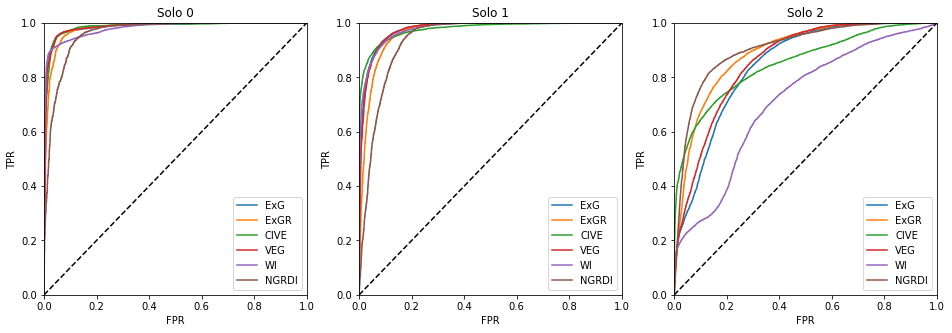

In [150]:
plt.figure(figsize=(16,5))
for soil in range(3):
    print("soil", soil)
    plt.subplot(1,3,soil+1)
    for col in VI_data:
        score = roc_auc_score(y.loc[solo == soil], VI_data.loc[solo == soil][col])
        fpr, tpr, th = roc_curve(y.loc[solo == soil], VI_data.loc[solo == soil][col])
        if score < .5:
            fpr, tpr = tpr, fpr
            score = 1 - score
        mean_acc, _ = getBestTreshold(fpr, tpr, th)
        VI_table.loc[soil, (col[:-5], "AUC")] = "%.1f" % (score * 100)
        VI_table.loc[soil, (col[:-5], "MeanAcc")] = "%.1f" % (mean_acc * 100)
        print(" > %-15s AUC = %.3f \t MeanAcc = %.3f" % (col, score, mean_acc))
        plt.plot(fpr, tpr, label = col[:-5])

    plt.title("Solo %d" % soil)
    plt.ylim((0,1))
    plt.xlim((0,1))
    plt.plot([0,1], [0,1], "k--")
    plt.ylabel("TPR")
    plt.xlabel("FPR")
    plt.legend();
plt.savefig("report1/figures/vi_soil.png")

In [17]:
pyperclip.copy(VI_table.to_latex())
VI_table

ExG          ExGR          CIVE           VEG            WI          \
       AUC MeanAcc   AUC MeanAcc   AUC MeanAcc   AUC MeanAcc   AUC MeanAcc   
Solo                                                                         
0     98.6    95.1  98.0    93.8  98.6    95.1  98.5    95.1  98.0    93.7   
1     97.8    92.2  96.5    91.0  97.7    92.1  97.6    92.1  97.7    91.7   
2     84.6    77.3  89.1    81.2  85.2    77.7  86.0    78.3  71.1    67.0   

     NGRDI          
       AUC MeanAcc  
Solo                
0     96.2    90.9  
1     93.8    88.6  
2     90.7    84.2

In [18]:
VI_AUC = VI_table.iloc[:, VI_table.columns.get_level_values(1)=='AUC']
VI_AUC.columns = VI_AUC.columns.droplevel(1)
pyperclip.copy(VI_AUC.to_latex())
VI_AUC

,ExG,ExGR,CIVE,VEG,WI,NGRDI
Solo,,,,,,
0,98.6,98.0,98.6,98.5,98.0,96.2
1,97.8,96.5,97.7,97.6,97.7,93.8
2,84.6,89.1,85.2,86.0,71.1,90.7


In [19]:
VI_meanacc = VI_table.iloc[:, VI_table.columns.get_level_values(1)=='MeanAcc']
VI_meanacc.columns = VI_meanacc.columns.droplevel(1)
pyperclip.copy(VI_meanacc.to_latex())
VI_meanacc

,ExG,ExGR,CIVE,VEG,WI,NGRDI
Solo,,,,,,
0,95.1,93.8,95.1,95.1,93.7,90.9
1,92.2,91.0,92.1,92.1,91.7,88.6
2,77.3,81.2,77.7,78.3,67.0,84.2


# 2) Train and generalization in the same soil type

### In this section, we train and generalize the learning in the same soil type for every soil type, and compare the results

In [20]:
reps = 5
score_matrix = np.zeros((3, 2, reps))

In [21]:
for i in set(solo):
    print("\n>>>> soil %d " %i)
    data_soil = data.loc[solo == i]
    print("LEN:", len(data_soil))
    y_soil = y.loc[solo == i]
    for j, (train_imgs, test_imgs) in enumerate(splitByImages(data_soil, .2, 5)):
        
        clf = XGBTrain2(data_soil.loc[IMG.isin(train_imgs)], y_soil.loc[IMG.isin(train_imgs)])
        
        prediction = clf.predict_proba(data_soil.loc[IMG.isin(test_imgs)])[:,-1]        
        score = roc_auc_score(y_soil.loc[IMG.isin(test_imgs)], prediction)
        fpr, tpr, th = roc_curve(y_soil.loc[IMG.isin(test_imgs)], prediction)
        if score < .5:
            fpr, tpr = tpr, fpr
            score = 1 - score
        mean_acc, _ = getBestTreshold(fpr, tpr, th)
        
        score_matrix[i, 0, j] = score
        score_matrix[i, 1, j] = mean_acc
        
        print("Best val-score: %.5f in %d iterations" % (clf.best_score, clf.best_iteration))
        print("AUC = %.3f \t MeanAcc = %.3f" % (score, mean_acc))


>>>> soil 0 
LEN: 19456
Best val-score: 0.98455 in 38 iterations
AUC = 0.949 	 MeanAcc = 0.860
Best val-score: 0.99655 in 34 iterations
AUC = 0.939 	 MeanAcc = 0.868
Best val-score: 0.99501 in 28 iterations
AUC = 0.965 	 MeanAcc = 0.915
Best val-score: 0.96750 in 23 iterations
AUC = 0.982 	 MeanAcc = 0.940
Best val-score: 0.96239 in 28 iterations
AUC = 0.997 	 MeanAcc = 0.977

>>>> soil 1 
LEN: 17408
Best val-score: 0.98234 in 14 iterations
AUC = 0.980 	 MeanAcc = 0.924
Best val-score: 0.98862 in 28 iterations
AUC = 0.980 	 MeanAcc = 0.927
Best val-score: 0.97850 in 30 iterations
AUC = 0.967 	 MeanAcc = 0.908
Best val-score: 0.99088 in 25 iterations
AUC = 0.984 	 MeanAcc = 0.928
Best val-score: 0.98806 in 21 iterations
AUC = 0.966 	 MeanAcc = 0.905

>>>> soil 2 
LEN: 22528
Best val-score: 0.97210 in 17 iterations
AUC = 0.891 	 MeanAcc = 0.810
Best val-score: 0.98800 in 42 iterations
AUC = 0.892 	 MeanAcc = 0.830
Best val-score: 0.97354 in 26 iterations
AUC = 0.972 	 MeanAcc = 0.918
Be

In [22]:
sm_mean = np.mean(score_matrix, axis = 2)
sm_std = np.std(score_matrix, axis = 2)

In [23]:
data_string = [ [ "%.3f ± %.3f" % (sm_mean[i,j], sm_std[i,j]) for j in range(sm_mean.shape[1])] \
               for i in range(sm_mean.shape[0])]
print(data_string)
data_string = "\\ \n".join([ " & ".join(row) for row in data_string])
data_string

[['0.967 ± 0.021', '0.912 ± 0.044'], ['0.976 ± 0.007', '0.918 ± 0.010'], ['0.937 ± 0.042', '0.877 ± 0.056']]


'0.967 ± 0.021 & 0.912 ± 0.044\\ \n0.976 ± 0.007 & 0.918 ± 0.010\\ \n0.937 ± 0.042 & 0.877 ± 0.056'

# 3) Train in one type of soil, test in each of the other two

In [24]:
reps = 5
score_matrix_auc = np.zeros((3, 3, reps)) # n_soils x n soils x n_reps
score_matrix_mac = np.zeros((3, 3, reps)) # n_soils x n soils x n_reps

In [50]:
clf.best_iteration, clf.best_ntree_limit

(174, 175)

In [72]:
clfs_single = [[None for _ in range(reps)] for _ in range (3)]
for i in set(solo):
    print("\n>>>> soil %d " %i)
    data_soil = data.loc[solo == i]
    print("LEN:", len(data_soil))
    y_soil = y.loc[solo == i]
    
    for k in range(reps):
        clf = XGBTrain2(data_soil, y_soil)
        clfs_single[i][k] = clf
        print("Best val-score: %.5f in %d iterations" % (clf.best_score, clf.best_iteration))
        
        for j in {0, 1, 2} - {i}:
            print("GENER soil: %d" % j)

            prediction = clf.predict_proba(data.loc[solo == j])[:,-1]        
            score = roc_auc_score(y.loc[solo == j], prediction)
            fpr, tpr, th = roc_curve(y.loc[solo == j], prediction)
            if score < .5:
                fpr, tpr = tpr, fpr
                score = 1 - score
            mean_acc, _ = getBestTreshold(fpr, tpr, th)
            
            score_matrix_auc[i, j, k] = score
            score_matrix_mac[i, j, k] = mean_acc
            
            print("AUC = %.3f \t MeanAcc = %.3f" % (score, mean_acc))


>>>> soil 0 
LEN: 19456
Best val-score: 0.99893 in 43 iterations
GENER soil: 1
AUC = 0.977 	 MeanAcc = 0.917
GENER soil: 2
AUC = 0.809 	 MeanAcc = 0.779
Best val-score: 0.96251 in 36 iterations
GENER soil: 1
AUC = 0.975 	 MeanAcc = 0.917
GENER soil: 2
AUC = 0.745 	 MeanAcc = 0.706
Best val-score: 0.99382 in 62 iterations
GENER soil: 1
AUC = 0.977 	 MeanAcc = 0.916
GENER soil: 2
AUC = 0.821 	 MeanAcc = 0.774
Best val-score: 0.99695 in 29 iterations
GENER soil: 1
AUC = 0.977 	 MeanAcc = 0.915
GENER soil: 2
AUC = 0.829 	 MeanAcc = 0.778
Best val-score: 0.98498 in 78 iterations
GENER soil: 1
AUC = 0.978 	 MeanAcc = 0.917
GENER soil: 2
AUC = 0.827 	 MeanAcc = 0.784

>>>> soil 1 
LEN: 17408
Best val-score: 0.98005 in 36 iterations
GENER soil: 0
AUC = 0.979 	 MeanAcc = 0.944
GENER soil: 2
AUC = 0.873 	 MeanAcc = 0.827
Best val-score: 0.97573 in 21 iterations
GENER soil: 0
AUC = 0.967 	 MeanAcc = 0.911
GENER soil: 2
AUC = 0.860 	 MeanAcc = 0.810
Best val-score: 0.98025 in 26 iterations
GENER 

In [151]:
sm_mean = np.mean(score_matrix_auc, axis = 2)
sm_std = np.std(score_matrix_auc, axis = 2)

data_string = [ [ "%.3f ± %.3f" % (sm_mean[i,j], sm_std[i,j]) for j in range(sm_mean.shape[1])] \
               for i in range(sm_mean.shape[0])]
data_string = "\\ \n".join([ " & ".join(row) for row in data_string])
data_string

'0.000 ± 0.000 & 0.977 ± 0.001 & 0.806 ± 0.031\\ \n0.963 ± 0.010 & 0.000 ± 0.000 & 0.861 ± 0.007\\ \n0.974 ± 0.002 & 0.927 ± 0.006 & 0.000 ± 0.000'

In [152]:
sm_mean = np.mean(score_matrix_mac, axis = 2)
sm_std = np.std(score_matrix_mac, axis = 2)

data_string = [ [ "%.3f ± %.3f" % (sm_mean[i,j], sm_std[i,j]) for j in range(sm_mean.shape[1])] \
               for i in range(sm_mean.shape[0])]
data_string = "\\ \n".join([ " & ".join(row) for row in data_string])
data_string

'0.000 ± 0.000 & 0.917 ± 0.001 & 0.764 ± 0.029\\ \n0.914 ± 0.017 & 0.000 ± 0.000 & 0.818 ± 0.006\\ \n0.910 ± 0.005 & 0.859 ± 0.005 & 0.000 ± 0.000'

# 4) Train in two type of soils, verify generalization in the other one

In [28]:
n_splits = 3
reps = 5

In [29]:
# group_kfold = GroupKFold(n_splits=n_splits)
group_kfold = LeaveOneGroupOut()

In [30]:
score_matrix = np.zeros((n_splits, 2, reps))

In [31]:
clfs = [[None for _ in range(reps)] for _ in range (n_splits)]
splits = list(group_kfold.split(data, y, groups=solo))

for i, (train_index, test_index) in enumerate(splits):
    print("out soil:", set(solo.iloc[test_index]))
    for j in range(5):
        clf = XGBTrain2(data.iloc[train_index], y.iloc[train_index])
        clfs[i][j] = clf

        prediction = clf.predict_proba(data.iloc[test_index])[:,-1] 
        score = roc_auc_score(y.iloc[test_index], prediction)
        fpr, tpr, th = roc_curve(y.iloc[test_index], prediction)
        if score < .5:
            fpr, tpr = tpr, fpr
            score = 1 - score
        mean_acc, _ = getBestTreshold(fpr, tpr, th)
        score_matrix[i, 0, j] = score
        score_matrix[i, 1, j] = mean_acc
        print(" > AUC = %.3f \t MeanAcc = %.3f" % (score, mean_acc))

out soil: {0}
 > AUC = 0.986 	 MeanAcc = 0.943
 > AUC = 0.982 	 MeanAcc = 0.935
 > AUC = 0.986 	 MeanAcc = 0.937
 > AUC = 0.985 	 MeanAcc = 0.937
 > AUC = 0.988 	 MeanAcc = 0.949
out soil: {1}
 > AUC = 0.963 	 MeanAcc = 0.900
 > AUC = 0.956 	 MeanAcc = 0.891
 > AUC = 0.968 	 MeanAcc = 0.902
 > AUC = 0.970 	 MeanAcc = 0.907
 > AUC = 0.966 	 MeanAcc = 0.905
out soil: {2}
 > AUC = 0.855 	 MeanAcc = 0.804
 > AUC = 0.889 	 MeanAcc = 0.832
 > AUC = 0.878 	 MeanAcc = 0.822
 > AUC = 0.863 	 MeanAcc = 0.805
 > AUC = 0.853 	 MeanAcc = 0.817


In [32]:
sm_mean = np.mean(score_matrix, axis = 2)
sm_std = np.std(score_matrix, axis = 2)

In [33]:
data_string = [ [ "%.3f ± %.3f" % (sm_mean[i,j], sm_std[i,j]) for j in range(sm_mean.shape[1])] \
               for i in range(sm_mean.shape[0])]
data_string = "\\ \n".join([ " & ".join(row) for row in data_string])
data_string

'0.985 ± 0.002 & 0.940 ± 0.005\\ \n0.965 ± 0.005 & 0.901 ± 0.006\\ \n0.868 ± 0.014 & 0.816 ± 0.010'

In [ ]:
# here we are taking the best features as and avarage of all types of training

In [35]:
fimp = sum( sum(clfs[i][j].feature_importances_ for i in range(n_splits)) for j in range(reps)) / (n_splits * reps)

In [36]:
importance = pd.Series(data=fimp, index=data.columns)
# importance = pd.Series(data=clf.feature_importances_, index=data.columns)

In [44]:
importance.sort_values(ascending=False)[:15]

WI_correlation_3*np.pi/2    0.222501
WI_mean                     0.054416
WI_correlation_np.pi/4      0.033629
NGRDI_interior_21           0.026423
NGRDI_max                   0.025006
NGRDI_interior_25           0.024261
NGRDI_mean                  0.022342
WI_min                      0.020790
WI_max                      0.017583
ExG_mean                    0.016968
NGRDI_std                   0.016369
WI_q75                      0.015760
NGRDI_interior_26           0.015108
WI_std                      0.014911
ExGR_mean                   0.011099
dtype: float32

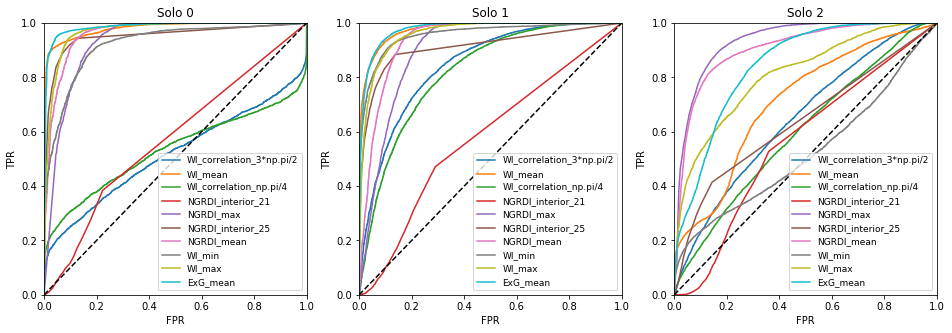

In [63]:
best_features = importance.sort_values(ascending=False).index[:10]

scores_auc2 = pd.DataFrame(None, columns = [0, 1, 2], index=best_features)
scores_mac2 = pd.DataFrame(None, columns = [0, 1, 2], index=best_features)

plt.figure(figsize=(16,5))
for soil in range(3):
    #print("\nsoil", soil)
    plt.subplot(1,3,soil+1)
    
    for col in best_features:
        score = roc_auc_score(y.loc[solo == soil], data.loc[solo == soil][col])
        fpr, tpr, th = roc_curve(y.loc[solo == soil], data.loc[solo == soil][col])
        if score < .5:
            fpr, tpr = tpr, fpr
            score = 1 - score
        mean_acc, _ = getBestTreshold(fpr, tpr, th)
        
        scores_auc2.loc[col, soil] = score
        scores_mac2.loc[col, soil] = mean_acc

        #print(" > %-30s AUC = %.3f \t MeanAcc = %.3f" % (col, score, mean_acc))
        plt.plot(fpr, tpr, label = col)
    
    plt.title("Solo %d" % soil)
    plt.ylim((0,1))
    plt.xlim((0,1))
    plt.plot([0,1], [0,1], "k--")
    plt.ylabel("TPR")
    plt.xlabel("FPR")
    plt.legend(prop={'size': 9})
    #plt.show()

In [64]:
scores_mac2 # notice theses features were selected as the best in the avarage of the 3 bases

,0,1,2
WI_correlation_3*np.pi/2,0.577631,0.765705,0.601064
WI_mean,0.936661,0.916749,0.670187
WI_correlation_np.pi/4,0.604668,0.745063,0.56798
NGRDI_interior_21,0.580619,0.590721,0.584016
NGRDI_max,0.869164,0.851407,0.86316
NGRDI_interior_25,0.911197,0.873492,0.635175
NGRDI_mean,0.909028,0.885891,0.842153
WI_min,0.857651,0.899295,0.569921
WI_max,0.924893,0.896778,0.735339
ExG_mean,0.951104,0.921793,0.772923


In [ ]:
# here we take best features for training in each base individualy (much more interesting)
# Plotar curvas aqui tbm pode ser interessante. Plotar as melhores de cada

In [73]:
fimp_single = [sum(clfs_single[i][j].feature_importances_ for j in range(reps)) / reps for i in range(3)]
importance_single = pd.DataFrame(data=None, columns=[0,1,2], index=data.columns)
for i in range(3):
    importance_single[i] = fimp_single[i]


In [78]:
importance_single.loc[importance_single.mean(axis = 1).sort_values(ascending=False)[:15].index]

,0,1,2
WI_correlation_3*np.pi/2,0.005056,0.070686,0.339315
WI_mean,0.070209,0.074183,0.041814
NGRDI_interior_21,0.024350,0.034393,0.021673
NGRDI_max,0.011979,0.030418,0.034752
VEG_correlation_7*np.pi/4,0.054974,0.012565,0.004478
ExG_mean,0.034292,0.022992,0.011521
WI_min,0.028964,0.012840,0.020388
WI_std,0.015280,0.020652,0.021083
WI_q75,0.022876,0.027450,0.004743
NGRDI_mean,0.009603,0.013782,0.029677


In [79]:
importance_single.loc[importance_single.max(axis = 1).sort_values(ascending=False)[:15].index]

,0,1,2
WI_correlation_3*np.pi/2,0.005056,0.070686,0.339315
WI_mean,0.070209,0.074183,0.041814
VEG_correlation_7*np.pi/4,0.054974,0.012565,0.004478
NGRDI_max,0.011979,0.030418,0.034752
NGRDI_interior_21,0.024350,0.034393,0.021673
ExG_mean,0.034292,0.022992,0.011521
NGRDI_interior_25,0.013681,0.004033,0.033633
NGRDI_mean,0.009603,0.013782,0.029677
WI_min,0.028964,0.012840,0.020388
ExG_correlation_np.pi/4,0.027518,0.001896,0.000765


In [160]:
_10bestminGain = importance_single.loc[importance_single.min(axis = 1).sort_values(ascending=False)[:20].index]
pyperclip.copy(_10bestminGain.to_latex())
_10bestminGain

,0,1,2
WI_mean,0.070209,0.074183,0.041814
NGRDI_interior_21,0.024350,0.034393,0.021673
WI_std,0.015280,0.020652,0.021083
NGRDI_std,0.014382,0.021737,0.013659
WI_max,0.013357,0.014688,0.024060
NGRDI_interior_26,0.013017,0.020766,0.013837
WI_min,0.028964,0.012840,0.020388
NGRDI_max,0.011979,0.030418,0.034752
ExG_mean,0.034292,0.022992,0.011521
NGRDI_mean,0.009603,0.013782,0.029677


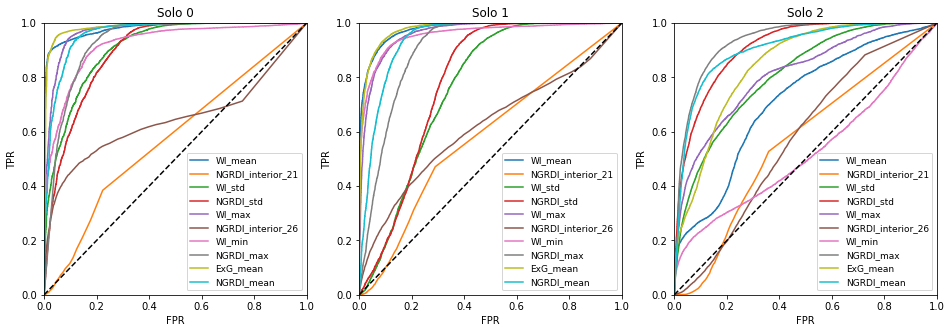

In [155]:
best_features = importance_single.min(axis = 1).sort_values(ascending=False)[:10].index


plt.figure(figsize=(16,5))
for soil in range(3):
    #print("\nsoil", soil)
    plt.subplot(1,3,soil+1)
    
    for col in best_features:
        score = roc_auc_score(y.loc[solo == soil], data.loc[solo == soil][col])
        fpr, tpr, th = roc_curve(y.loc[solo == soil], data.loc[solo == soil][col])
        if score < .5:
            fpr, tpr = tpr, fpr
            score = 1 - score
        mean_acc, _ = getBestTreshold(fpr, tpr, th)
        

        #print(" > %-30s AUC = %.3f \t MeanAcc = %.3f" % (col, score, mean_acc))
        plt.plot(fpr, tpr, label = col)
    
    plt.title("Solo %d" % soil)
    plt.ylim((0,1))
    plt.xlim((0,1))
    plt.plot([0,1], [0,1], "k--")
    plt.ylabel("TPR")
    plt.xlabel("FPR")
    plt.legend(prop={'size': 9})
    #plt.show()
plt.savefig("report1/figures/10bestminGainFeatures.png")

# Análise do Resultados

In [87]:
clf_ind = 2 # base 2 out is better to find out why training in 0 and 1 fail in generalizing to 2
clf = clfs[clf_ind][0]

train_index, test_index = splits[clf_ind]
X_train, y_train = data.iloc[train_index], y.iloc[train_index]
X_test, y_test = data.iloc[test_index], y.iloc[test_index]

predict = clf.predict_proba(X_test, ntree_limit=clf.best_iteration)[:,-1]

 > NGRDI_max                      AUC = 0.934 	 MeanAcc = 0.863
 > NGRDI_mean                     AUC = 0.907 	 MeanAcc = 0.842
 > ExGR_max                       AUC = 0.923 	 MeanAcc = 0.839
 > NGRDI_std                      AUC = 0.910 	 MeanAcc = 0.824
 > ExGR_std                       AUC = 0.905 	 MeanAcc = 0.823
 > VEG_std                        AUC = 0.897 	 MeanAcc = 0.814
 > ExGR_mean                      AUC = 0.891 	 MeanAcc = 0.812
 > VEG_max                        AUC = 0.904 	 MeanAcc = 0.807
 > CIVE_std                       AUC = 0.888 	 MeanAcc = 0.805
 > ExG_std                        AUC = 0.885 	 MeanAcc = 0.802
 > predict                        AUC = 0.854 	 MeanAcc = 0.805


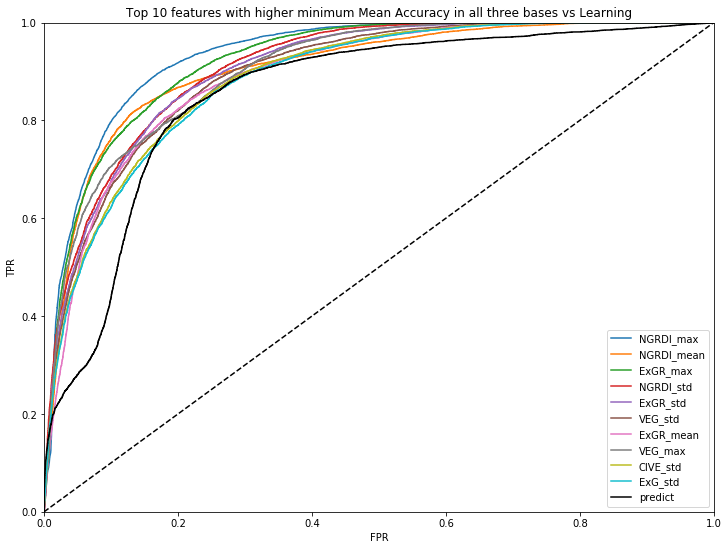

In [162]:
plt.figure(figsize=(12,9))
for col in scores_mac[2].sort_values(ascending=False).index[:10]:
    score = roc_auc_score(y.loc[solo==2], data.loc[solo==2][col])
    fpr, tpr, th = roc_curve(y.loc[solo==2], data.loc[solo==2][col])
    if score < .5:
        fpr, tpr = tpr, fpr
        score = 1 - score
    mean_acc, _ = getBestTreshold(fpr, tpr, th)
    print(" > %-30s AUC = %.3f \t MeanAcc = %.3f" % (col, score, mean_acc))
    plt.plot(fpr, tpr, label = col)

score = roc_auc_score(y_test, predict)   
FPR, TPR, TH = roc_curve(y_test, predict)
mean_acc, _ = getBestTreshold(FPR, TPR, TH)
print(" > %-30s AUC = %.3f \t MeanAcc = %.3f" % ("predict", score, mean_acc))
plt.plot(FPR,TPR, "k-", label = "predict", lw = 1.5)

plt.title("Top 10 features with higher minimum Mean Accuracy in all three bases vs Learning")
plt.ylim((0,1))
plt.xlim((0,1))
plt.plot([0,1], [0,1], "k--")
plt.ylabel("TPR")
plt.xlabel("FPR")
plt.legend();
plt.savefig("report1/figures/prediction_vs_bestFeatures.png")

 > WI_correlation_3*np.pi/2       AUC = 0.648 	 MeanAcc = 0.601
 > WI_mean                        AUC = 0.711 	 MeanAcc = 0.670
 > NGRDI_max                      AUC = 0.934 	 MeanAcc = 0.863
 > NGRDI_interior_25              AUC = 0.640 	 MeanAcc = 0.635
 > NGRDI_mean                     AUC = 0.907 	 MeanAcc = 0.842
 > WI_max                         AUC = 0.811 	 MeanAcc = 0.735
 > NGRDI_interior_21              AUC = 0.562 	 MeanAcc = 0.584
 > WI_std                         AUC = 0.808 	 MeanAcc = 0.720
 > WI_min                         AUC = 0.523 	 MeanAcc = 0.570
 > WI_correlation_np.pi/4         AUC = 0.599 	 MeanAcc = 0.568
 > predict                        AUC = 0.854 	 MeanAcc = 0.805


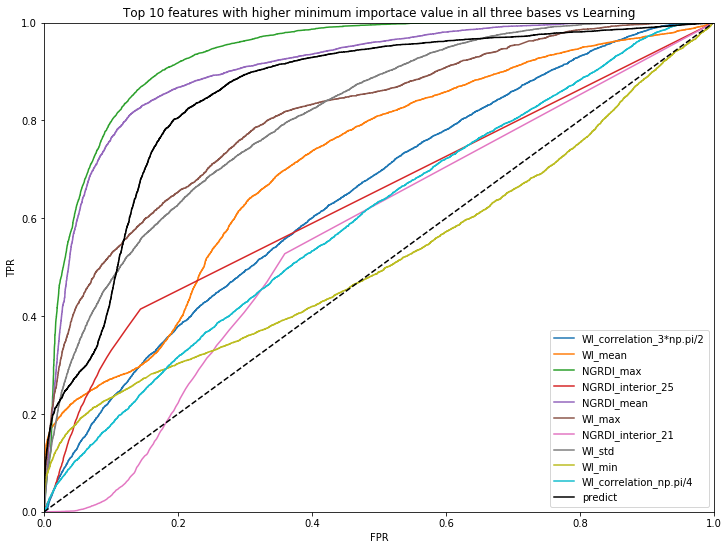

In [164]:
plt.figure(figsize=(12,9))
for col in importance_single[2].sort_values(ascending=False)[:10].index:
    score = roc_auc_score(y.loc[solo==2], data.loc[solo==2][col])
    fpr, tpr, th = roc_curve(y.loc[solo==2], data.loc[solo==2][col])
    if score < .5:
        fpr, tpr = tpr, fpr
        score = 1 - score
    mean_acc, _ = getBestTreshold(fpr, tpr, th)
    print(" > %-30s AUC = %.3f \t MeanAcc = %.3f" % (col, score, mean_acc))
    plt.plot(fpr, tpr, label = col)

score = roc_auc_score(y_test, predict)   
FPR, TPR, TH = roc_curve(y_test, predict)
mean_acc, _ = getBestTreshold(FPR, TPR, TH)
print(" > %-30s AUC = %.3f \t MeanAcc = %.3f" % ("predict", score, mean_acc))
plt.plot(FPR,TPR, "k-", label = "predict", lw = 1.5)

plt.title("Top 10 features with higher minimum importace value in all three bases vs Learning")
plt.ylim((0,1))
plt.xlim((0,1))
plt.plot([0,1], [0,1], "k--")
plt.ylabel("TPR")
plt.xlabel("FPR")
plt.legend()
plt.savefig("report1/figures/10bestminGAIN_vs_predict")

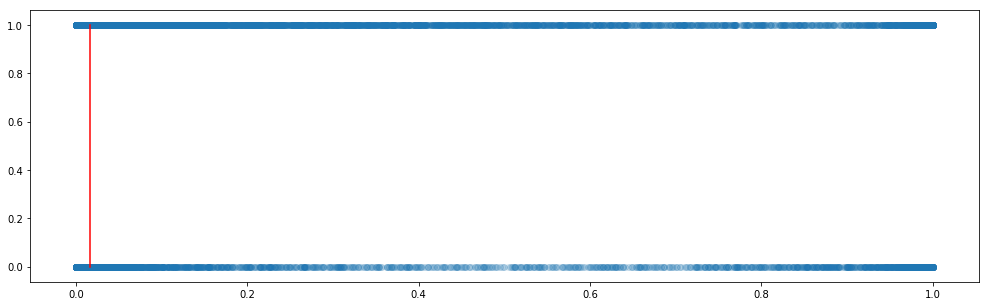

In [91]:
plt.figure(figsize=(17,5))
plt.scatter(predict, y_test, alpha = .1)
th = TH[th_ix]
plt.plot([th, th], [1,0], "r-")

In [92]:
train_pred = clf.predict_proba(data, ntree_limit=clf.best_iteration)[:,-1]

In [93]:
m1 = ((y == 1) & (train_pred < th))
m0 = ((y == 0) & (train_pred > th))
m1.sum(), m0.sum()

(1336, 6293)

In [94]:
dec = PCA()

In [95]:
pca = dec.fit_transform(StandardScaler().fit_transform(data.fillna(10**-5)))

<BarContainer object of 30 artists>

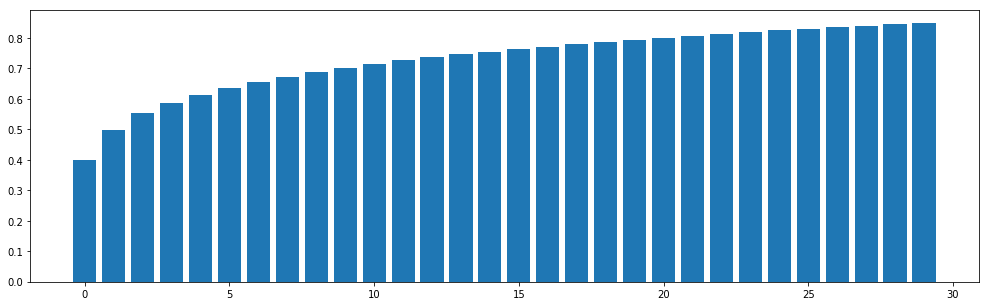

In [96]:
plt.figure(figsize=(17,5))
xvr = dec.explained_variance_ratio_[:30]
plt.bar(range(len(xvr)), np.cumsum(xvr))

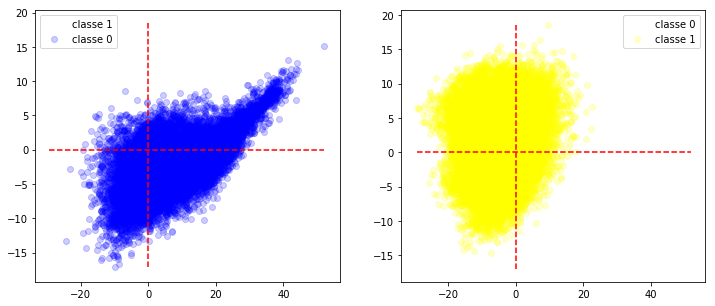

In [97]:
plt.figure(figsize=(12,5))
for c in {0,1}:
    plt.subplot(1,2,c+1)
    plt.scatter(pca[y==(1-c),0], pca[y==(1-c),1], alpha = 0 * .2, label = "classe %d" % (1-c))
    plt.scatter(pca[y==c,0], pca[y==c,1], alpha = .2, label = "classe %d" % c, color = "blue" if c == 0 else "yellow")
    plt.plot([0,0], [pca[:,1].min(), pca[:,1].max()], "r--")
    plt.plot([pca[:,0].min(), pca[:,0].max()], [0,0], "r--")
    plt.legend()

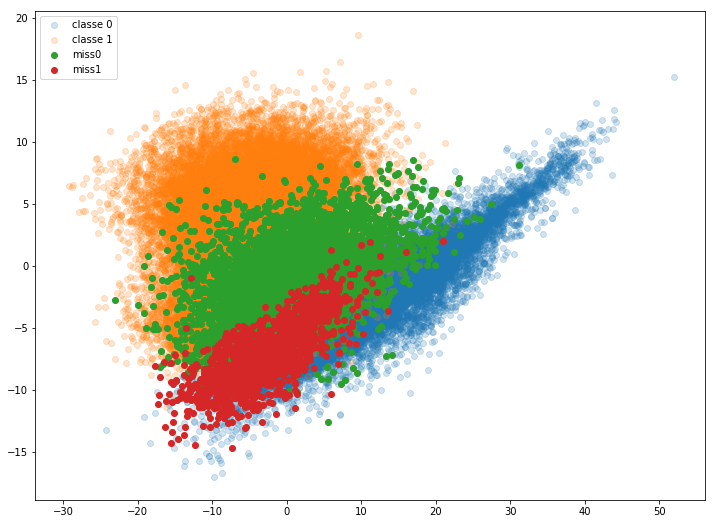

In [98]:
plt.figure(figsize=(12,9))
for c in {0,1}:
    plt.scatter(pca[y==c,0], pca[y==c,1], alpha = .2, label = "classe %d" % c)
plt.scatter(pca[m0,0], pca[m0,1], label = "miss0")
plt.scatter(pca[m1,0], pca[m1,1], label = "miss1")
plt.legend()

In [99]:
from skimage.util.shape import view_as_blocks
from skimage.io import imread


In [115]:
paths = ["imgs_orig", "gts_orig"] # TROCAR AQUI DEPENDENDO DA BASE

path_imgs = sorted([ paths[0] + '/' + i for i in listdir(paths[0]) ])
path_gts = sorted([ paths[1] + '/' + i for i in listdir(paths[1]) ])


paths2 = ["imgs", "gts"] # TROCAR AQUI DEPENDENDO DA BASE

path_imgs2 = sorted([ paths2[0] + '/' + i for i in listdir(paths2[0]) ])
path_gts2 = sorted([ paths2[1] + '/' + i for i in listdir(paths2[1]) ])

In [116]:
misses = pd.concat([IMG[m0].value_counts().rename("NOVEG-miss"), IMG[m1].value_counts().rename("VEG-miss")], axis = 1).fillna(0)

In [117]:
misses["sum"] = misses["NOVEG-miss"] + misses["VEG-miss"]

In [118]:
misses.sort_values("sum",ascending=False)

,NOVEG-miss,VEG-miss,sum
50,711,0.0,711.0
52,1,545.0,546.0
59,20,427.0,447.0
57,378,0.0,378.0
48,366,0.0,366.0
49,364,1.0,365.0
40,278,0.0,278.0
46,252,1.0,253.0
41,228,1.0,229.0
60,3,224.0,227.0


In [119]:
def highlight(ind, color):
    x_ini = (ind % 32) * 16
    x_end = x_ini + 15
    y_ini = (ind // 32) * 16
    y_end = y_ini + 15
    plt.fill_between([x_ini, x_end], y_ini, y_end, alpha =.4, color = color)

In [181]:
i = 41
if i >= 40:
    img = imread(path_imgs2[i-40])
    gt = imread(path_gts2[i-40], as_grey=True)
else:
    img = imread(path_imgs[i])
    gt = imread(path_gts[i], as_grey=True)


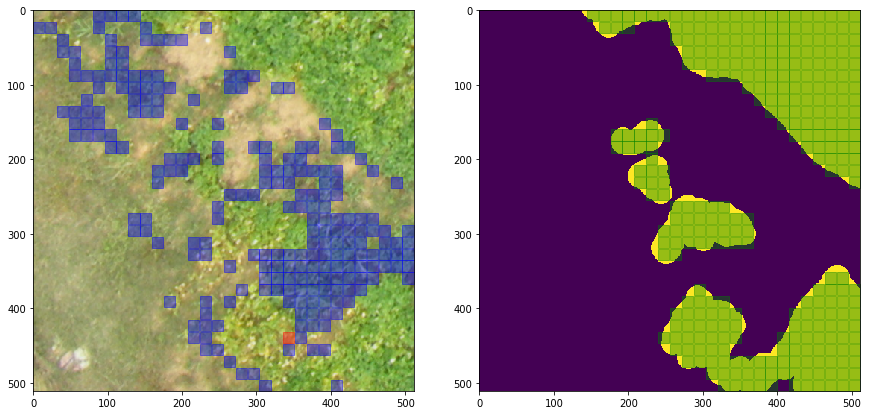

In [182]:
plt.figure(figsize=(16,7))
plt.subplots_adjust(wspace = 0, hspace = 0)

plt.subplot(1,2,1)
plt.imshow(img)
for b in BLOCK[(IMG == i) & m1]:
    highlight(b, "red")
for b in BLOCK[(IMG == i) & m0]:
    highlight(b, "blue")
plt.ylim((511,0))
plt.xlim((0,511))

plt.subplot(1,2,2)
plt.imshow(gt)
for b in BLOCK[(IMG == i) & (y == 1)]:
    highlight(b, "green")
plt.ylim((511,0))
plt.xlim((0,511))

plt.savefig("report1/figures/errovisu%02d.png" % i)